# **Introductions**

To continue with 3.9 and finish shap and dpd to select a few features from each categories.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import datetime
import shap
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = "/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_times_analysis.csv"

In [5]:
df_raw = pd.read_csv(file_path)

In [6]:
df = df_raw.copy()

In [7]:
df.columns, df.shape

(Index(['Unnamed: 0', 'primary_key', 'bbl', 'court_index_number',
        'docket_number', 'eviction_address', 'eviction_apartment_number',
        'executed_date', 'borough', 'zipcode',
        ...
        'total_complaints', 'building_age', 'style_ordinal', 'style_freq',
        'style_label', 'building_category_ordinal', 'building_category_freq',
        'building_category_le', 'age_bin', 'age_group'],
       dtype='object', length=102),
 (66397, 102))

In [ ]:
# model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
# model_rfr_svi.fit(X_train, y_train)

In [ ]:
# list(df.columns)

In [8]:
df.svi_quartile.unique()
# these are strings, and will not work with the analysis.

array(['Q3', 'Q4 (High)', 'Q2', 'Q1 (Low)'], dtype=object)

In [9]:
df.svi_quartile = df.svi_quartile.str.extract(r'Q(\d)').astype(int)

In [10]:
df.svi_quartile.unique(), df.svi_quartile[0].dtype

(array([3, 4, 2, 1]), dtype('int64'))

In [11]:
svi_vars = ['rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4', 'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
  'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh', 'ep_crowd', 'ep_hburd', 'ep_afam', 'ep_hisp', 'ep_asian', 'ep_aian',
  'ep_nhpi', 'ep_twomore', 'ep_otherrace', 'ep_minrty', 'ep_white', 'svi_quartile']

In [12]:
new_building_vars = ['numfloors', 'building_category_ordinal', 'unitsres', 'bldgarea', 'building_type', 'is_condo', 'is_llc',
  'style_ordinal', 'building_age', 'floor_category', 'size_quartile', 'building_size_category', 'residential_units_category']

In [13]:
complaints_vars = ['air_quality', 'animal_issues', 'appliances', 'building_exterior', 'doors_windows', 'electrical_issues',
  'elevator_issues', 'floors_stairs', 'general_complaints', 'graffiti_posting', 'heat_hot_water', 'homeless_issues', 'noise_complaints',
  'other_issues', 'pest_issues', 'plumbing_issues', 'police_matters', 'public_nuisance',
  'safety_concerns', 'sanitation_issues', 'walls_ceilings','total_complaints']

In [14]:
all_vars = svi_vars + new_building_vars + complaints_vars
# since we are already here.

In [ ]:
# df.svi_group.unique()

In [ ]:
X_svi = df[svi_vars]
y_svi = df['average_year_eviction_count']
X_building = df[new_building_vars]
y_building = df['average_year_eviction_count']
X_311 = df[complaints_vars]
y_311 = df['average_year_eviction_count']

In [15]:
X_all = df[all_vars]
y_all = df['average_year_eviction_count']

In [ ]:
X_train_svi, X_test_svi, y_train_svi, y_test_svi = train_test_split(X_svi, y_svi, test_size=0.2, random_state=42)

In [ ]:
X_train_building, X_test_building, y_train_building, y_test_building = train_test_split(X_building, y_building, test_size=0.2, random_state=42)

In [ ]:
X_train_311, X_test_311, y_train_311, y_test_311 = train_test_split(X_311, y_311, test_size=0.2, random_state=42)

In [16]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [ ]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train_svi, y_train_svi)

RandomForestRegressor(random_state=42)

In [ ]:
model_rfr_311 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_311.fit(X_train_311, y_train_311)

RandomForestRegressor(random_state=42)

In [ ]:
model_rfr_building = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_building.fit(X_train_building, y_train_building)

RandomForestRegressor(random_state=42)

In [17]:
model_rfr_all = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_all.fit(X_train_all, y_train_all)

RandomForestRegressor(random_state=42)

PermutationExplainer explainer: 501it [02:54,  2.76it/s]


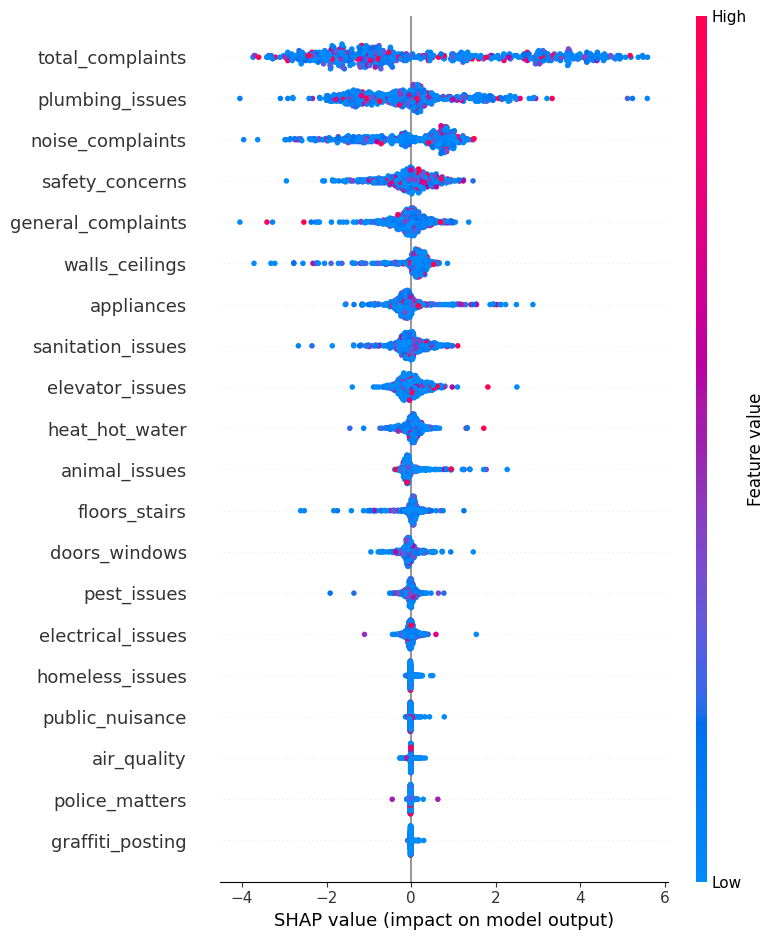

In [ ]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_311.predict, X_311)
# explainer = shap.TreeExplainer(model_rfr_311.predict)
explainer = shap.Explainer(model_rfr_311.predict, X_311)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X_311.sample(n=500))
shap.summary_plot(shap_values, X_311.sample(n=500))

PermutationExplainer explainer: 501it [02:16,  3.40it/s]


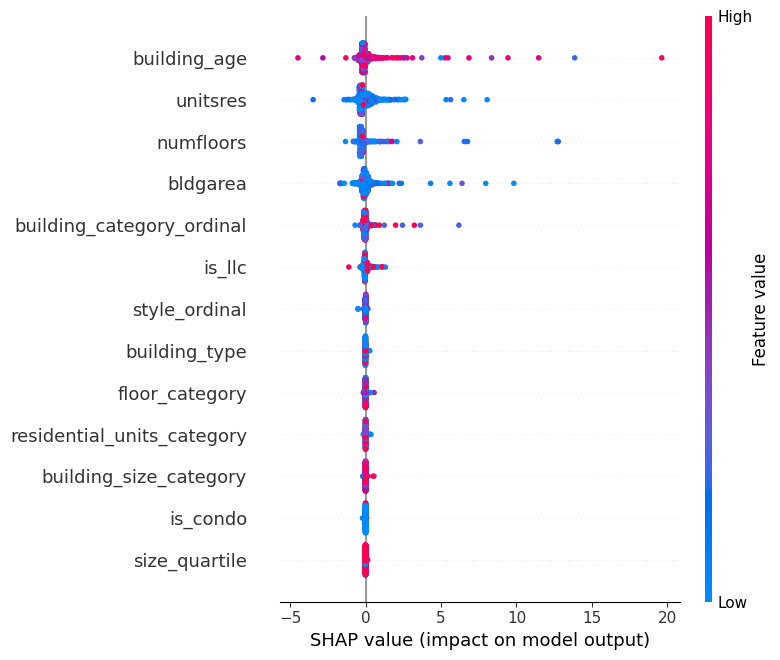

In [ ]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_building.predict, X_building)
explainer = shap.Explainer(model_rfr_building.predict, X_building)
shap_values = explainer.shap_values(X_building.sample(n=500))
shap.summary_plot(shap_values, X_building.sample(n=500))

PermutationExplainer explainer: 501it [01:45,  4.31it/s]


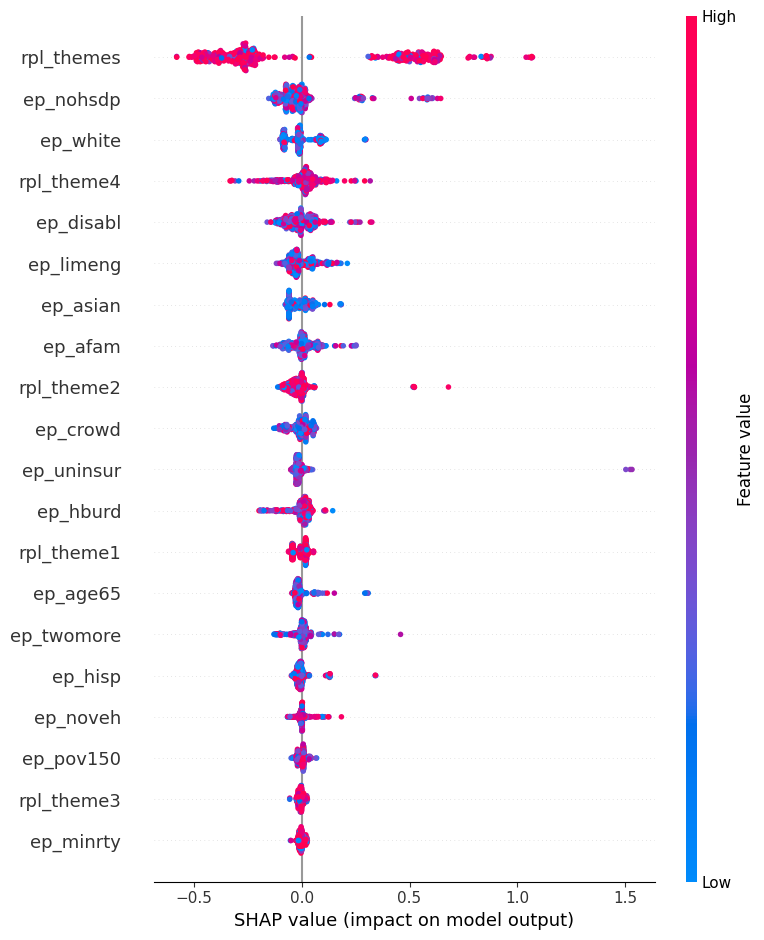

In [ ]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X_svi)
explainer = shap.Explainer(model_rfr_svi.predict, X_svi)
shap_values = explainer.shap_values(X_svi.sample(n=500))
shap.summary_plot(shap_values, X_svi.sample(n=500))

PermutationExplainer explainer: 501it [06:33,  1.25it/s]


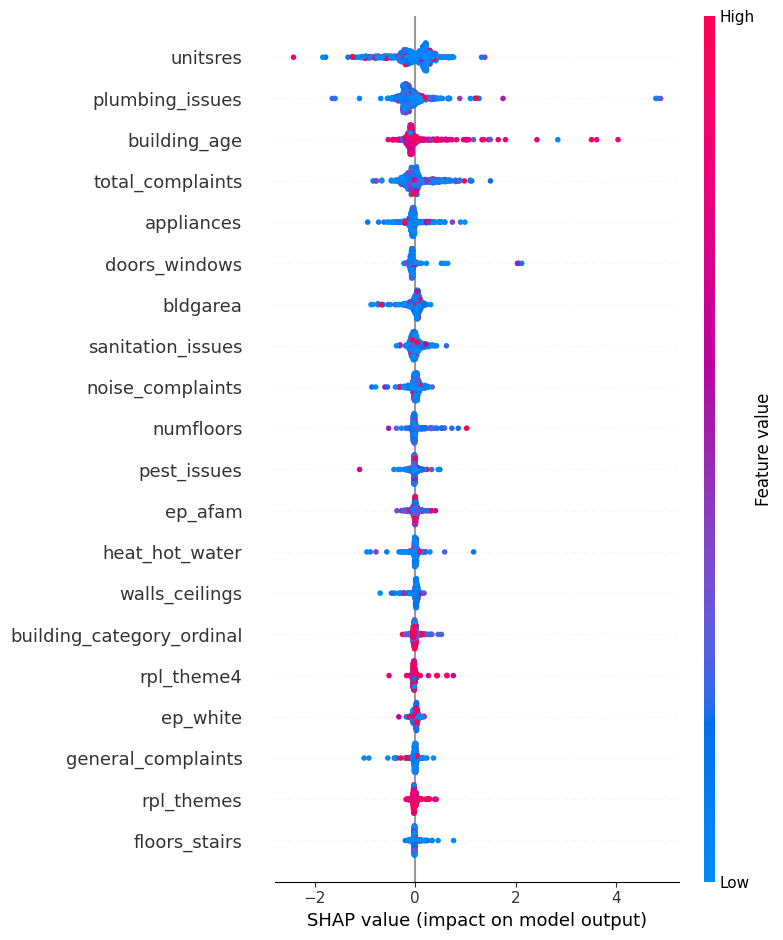

In [18]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_all.predict, X_all)
explainer = shap.Explainer(model_rfr_all.predict, X_all)
shap_values = explainer.shap_values(X_all.sample(n=500))
shap.summary_plot(shap_values, X_all.sample(n=500))

In [21]:
X_sample = X_all.sample(n=500, random_state=0)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_feature_importance = pd.Series(mean_abs_shap, index=X_sample.columns)
top_features = shap_feature_importance.sort_values(ascending=False)
top_features.head(10)
# no surprise

,0
unitsres,0.294515
plumbing_issues,0.225193
building_age,0.190246
total_complaints,0.169255
appliances,0.101068
doors_windows,0.088081
bldgarea,0.080855
sanitation_issues,0.067740
noise_complaints,0.059567
numfloors,0.055036


## **In summary, given all analysis (linear, mis, rfr, dt, and shap). We will work with these features in the next notebooks:**

Building features: \
bldgarea – strongest across MI, correlation, and feature importance. Larger buildings are associated with more evictions. \

building_age – older buildings tend to have higher eviction rates, seen in decision tree and partial dependence plots. \

unitsres – number of residential units is consistently predictive, especially in mutual information and feature importance. \

numfloors – more floors often correlate with higher eviction counts. \

is_llc – LLC-owned buildings show a subtle but consistent positive impact on eviction rate in SHAP/PDP plots. \



311 features: \

plumbing_issues – first feature across almost all model types and SHAP plots.

total_complaints – high predictive power across correlation, mutual info, and feature importances.

noise_complaints – strong predictor of eviction activity; captures tenant distress or instability.

doors_windows – often in the top 5 in feature importance and decision tree visualizations.

heat_hot_water – partial dependence plots show steep rises in eviction risk at low service levels.

(runner-ups: sanitation_issues, walls_ceilings, general_complaints)

svi features: \

rpl_themes – composite SVI score, ranked #1 in multiple charts.

ep_uninsur – percentage of uninsured population is consistently high in importance.

ep_nohsdp – % of without high school diploma is also strongly predictive.

rpl_theme2 – socioeconomic vulnerability (subset theme of rpl_themes) is significant.

ep_hisp / ep_limeng / ep_age65 – tied in importance across methods, depending on model type.